In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

from fractions import Fraction

## 理想的な回路作成

In [2]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('$2^5$個のデータ')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.show()

### 動作の確認
まずは5量子ビットのアルゴリズムを実装し、動作を確認する。

初期状態$|0 \cdots 0\rangle$を作成

In [3]:
nqubits = 3
times = 4
import matplotlib.ticker as ticker
# plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
state = QuantumState(nqubits)
state.set_zero_state()

次にアダマールゲートを作成する
$$
    H = \frac{1}{\sqrt(2)}(|0\rangle \langle 0| + |1\rangle \langle 0| + |0\rangle \langle 1| + |1\rangle \langle 1|)
$$

In [4]:

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard


このアダマールゲートを初期状態$|0 \cdots 0\rangle$に作用させる。

$$
|s\rangle = (H \otimes \cdots \otimes H)|0 \cdots 0\rangle \\

= \frac{1}{(\sqrt{2})^n}(| 0 \rangle + | 1 \rangle) \otimes \cdots \otimes (| 0 \rangle + | 1 \rangle)\\

= \frac{1}{(\sqrt{2})^n} (|00 \cdots 00 \rangle + | 00 \cdots 01 \rangle + \cdots + | 11 \cdots 10\rangle + |11 \cdots 11 \rangle) \\

|s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0}^{2^n - 1} |x\rangle
$$

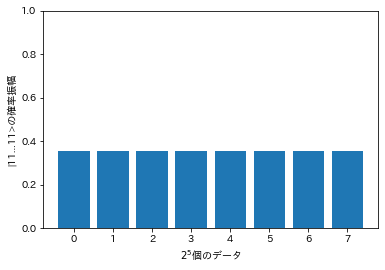

In [5]:
Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

次に解に対する反転操作をする、オラクル$U_w$を作成する。

入力$|x\rangle$に対して$x$が解なら、$-1$を掛けて位相を反転し、解でないなら$1$を掛ける。


$$
\begin{cases}
    U_w|x\rangle = |x\rangle (x \neq w) \\
    U_w|w\rangle = -|w\rangle
  \end{cases}
$$

$$
U_w = I - 2 \sum_{w \in \text{解}} |w\rangle \langle w|
$$

In [6]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

これを作用させると$|s\rangle$
$$
U_w |s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} U_w |x\rangle + \frac{1}{(\sqrt{2})^n} U_w |x\rangle \\

= \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} |x\rangle - \frac{1}{(\sqrt{2})^n}|w\rangle \\

= \left( |s\rangle - \frac{1}{(\sqrt{2})^n} |w\rangle \right) - \frac{1}{(\sqrt{2})^n} |w\rangle \\

U_w |s\rangle = |s\rangle - \frac{2}{(\sqrt{2})^n} |w\rangle
$$

となる。

In [7]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j -0.35355339+0.j]


最後に$|s\rangle$を対象軸にした反転操作$U_s$を定義する

$$
U_s = 2|s\rangle \langle s| - I = H^{\otimes n}(2 |0 \cdots 0\rangle \langle 0 \cdots 0| - I)H^{\otimes n}
$$

$$
\begin{cases}
    U_s |x\rangle = 2\langle s|x|s\rangle - |x\rangle = \frac{2}{\sqrt{2^n}} |x\rangle \\
    U_s |s\rangle = 2\langle s|s|s\rangle - |s\rangle = |s\rangle
 \end{cases}
$$

In [8]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

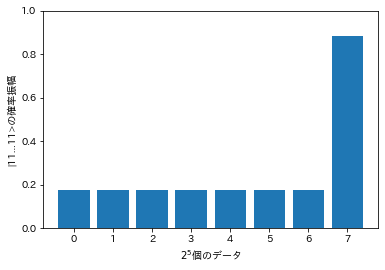

In [9]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

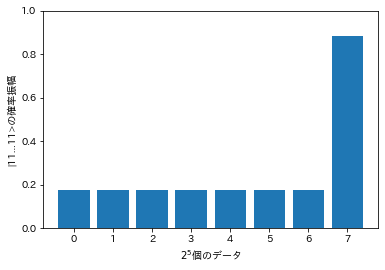

0.8838834764831837


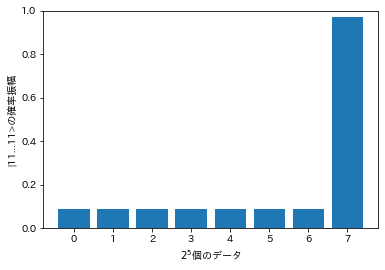

0.9722718241315015


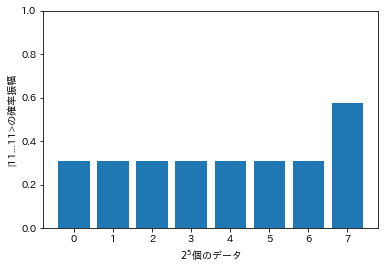

0.5745242597140687


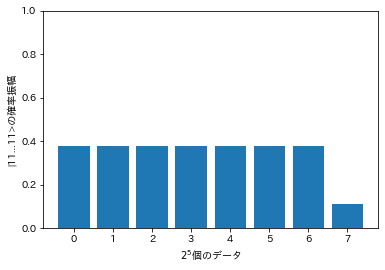

0.11048543456039785


In [10]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

0.8838834764831837
0.9722718241315015
0.5745242597140687
0.11048543456039785


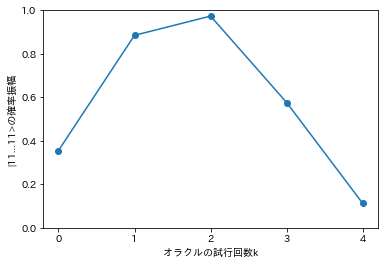

In [11]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

avg_result = []
hoge = np.linalg.norm(inner_product(state, target_state))
avg_result.append(hoge)
for i in range(times):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.xlabel('オラクルの試行回数k')
plt.ylabel('|11...11>の確率振幅')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 5, step=1))
plt.plot(avg_result, "o-")

In [12]:
# グローバーのアルゴリズム
def grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 5, step=1))
    plt.show()

0.8838834764831837
0.9722718241315015
0.5745242597140687
0.11048543456039785
maximal probability 9.722718e-01 is obtained at k = 2


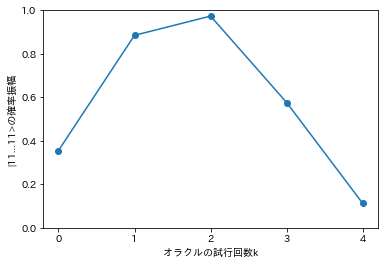

In [13]:
grover(nqubits, times)

## ノイズを入れてみる。
http://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#id37

In [14]:
from qulacs.gate import DephasingNoise
from qulacs.gate import Probabilistic

[こちらを参考にして](https://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html?highlight=distribution#id39)、確率pでパウリ演算子Iを作用させる


In [15]:
def make_noisy_Hadamard(nqubits, dephasing_rate):
    Hadamard = QuantumCircuit(nqubits)

    distribution = [1 - float(Fraction(f'{dephasing_rate}')), dephasing_rate]
    float(Fraction('0.1'))
    for i in range(nqubits):
        gate_list = [H(i), Identity(i)]
        gate = Probabilistic(distribution, gate_list)
        # Hadamard.add_gate(H(i))
        Hadamard.add_gate(gate)
    return Hadamard

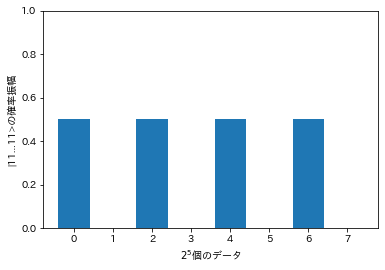

[0.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0.5+0.j 0. +0.j]


In [16]:
dephasing_rate = 0.5
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)
print(state.get_vector())

In [17]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[0.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0.5+0.j 0. +0.j]


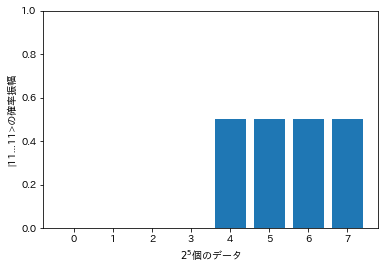

In [18]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

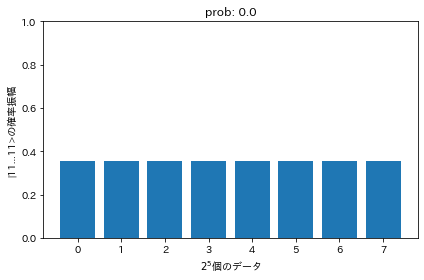

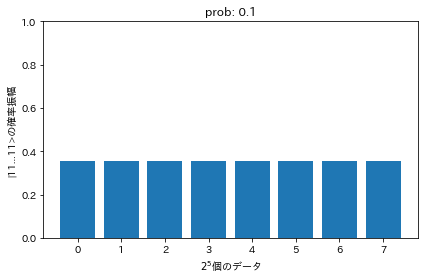

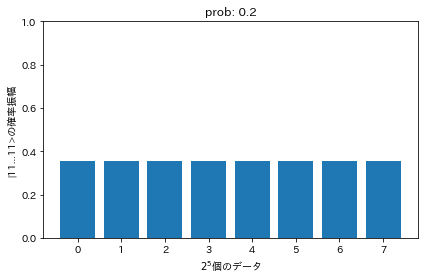

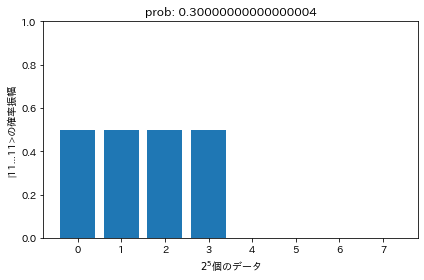

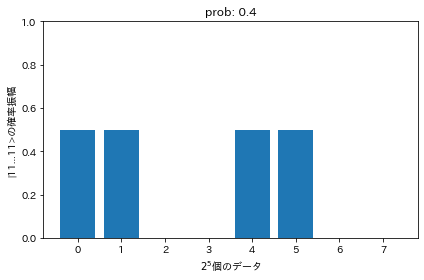

In [19]:
for i in range(0, times + 1):
    dephasing_rate = i * 0.1 # p = dephasing_rateとして計算
    state = QuantumState(nqubits)
    state.set_zero_state()

    Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    Hadamard.update_quantum_state(state)

    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'prob: {dephasing_rate}')
    plt.xlabel('2^5個のデータ')
    plt.ylabel('確率')
    show_distribution(state, nqubits)


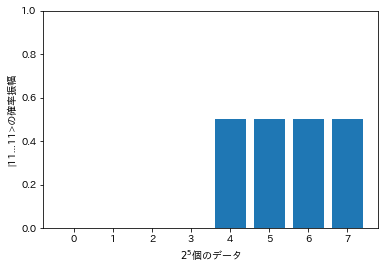

0.49999999999999967


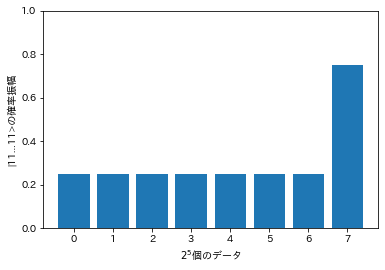

0.7499999999999991


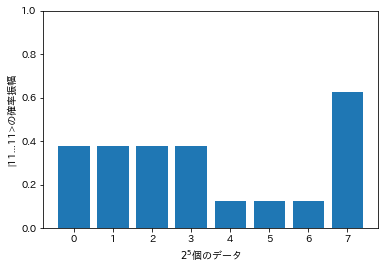

0.624999999999999


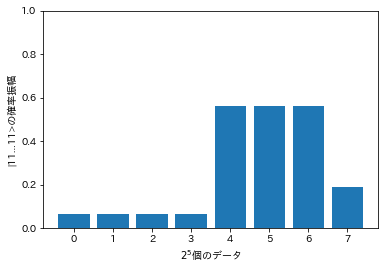

0.18749999999999958


In [20]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

0.35355339059327356
0.5303300858899102
0.44194173824159144
0.13258252147247743


(0.0, 1.0)

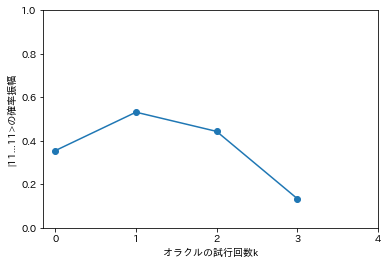

In [21]:
Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

avg_result = []
for i in range(times):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.plot(avg_result, "-o")
plt.xlabel('オラクルの試行回数k')
plt.ylabel('|11...11>の確率振幅')
plt.xticks(np.arange(0, 5, step=1))
plt.ylim(0, 1)


In [22]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.xticks(np.arange(0, 5, step=1))
    plt.ylim(0, 1)


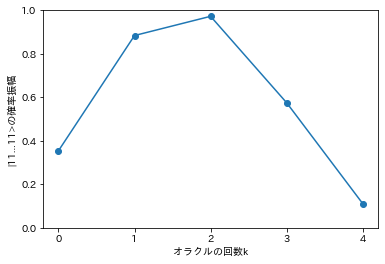

In [23]:
noisy_grover(nqubits, times, 0.5)

0.0
0.1
0.2
0.30000000000000004
0.4


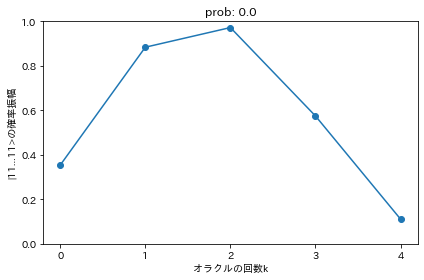

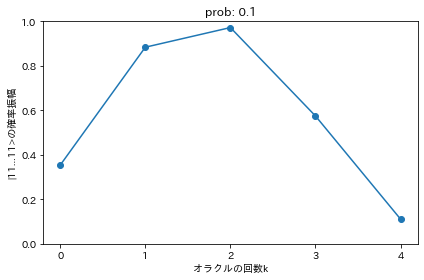

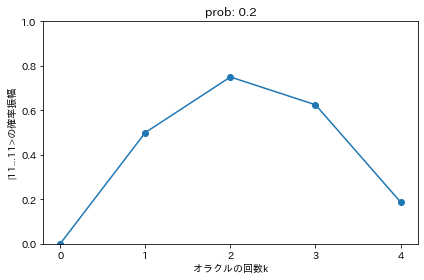

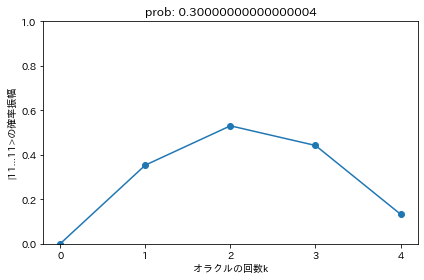

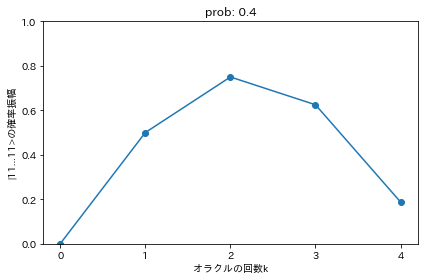

In [24]:
max_result = []
for i in range(0, times + 1):
    x = i * 0.1
    print(x)
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'prob: {x}')
    plt.xticks(np.arange(0, 5, step=1))
    noisy_grover(nqubits, times, x)

In [25]:
max_result = []
def noisy_I_grover(nqubits, times):
    for i in range(0, times + 1):
        x = i * 0.1
        noisy_grover(nqubits, times, x)
    # print(max_result)
    # plt.plot(max_result)

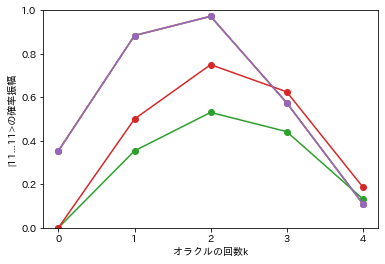

In [26]:
noisy_I_grover(nqubits, times)

[0.9722718241315015, 0.9722718241315015, 0.5303300858899102, 0.7499999999999991, 0.9722718241315015]


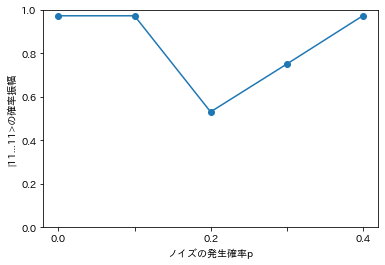

In [27]:
print(max_result)
plt.plot(max_result, "-o")
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, times + 1, 2), [i/10 for i in range(0, times + 1, 2) ])
plt.ylabel('|11...11>の確率振幅')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 5, step=1))


plt.show()


In [28]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover_1(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('確率')


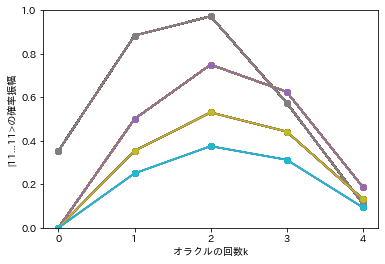

In [29]:
sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_I_grover(nqubits, times)
    # print(f'max result:{max_result}')
    total_result.append(max_result)

[0.9722718241315015, 0.9722718241315015, 0.9722718241315015]
[0.9722718241315015, 0.7499999999999991, 0.9722718241315015]
[0.7499999999999991, 0.9722718241315015, 0.7499999999999991]
[0.5303300858899102, 0.9722718241315015, 0.7499999999999991]
[0.7499999999999991, 0.7499999999999991, 0.5303300858899102]


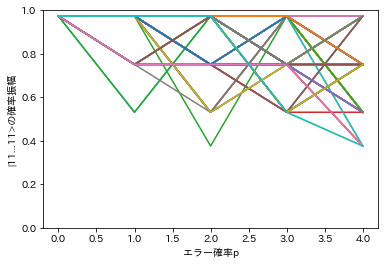

In [30]:
for j in total_result:
    plt.xlabel('エラー確率p')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)

    plt.plot(j)

result = []
for i in range(times + 1):
    hoge = []
    for j in range(nqubits):
        tmp = total_result[j][i]
        hoge.append(tmp)
    print(hoge)
    result.append(hoge)

In [31]:
# boxplot_result = result
# print(boxplot_result)
# plt.boxplot(boxplot_result)
# plt.show()

平均結果:[0.9722718241315015, 0.8981812160876673, 0.8240906080438332, 0.7508673033404701, 0.6767766952966361]


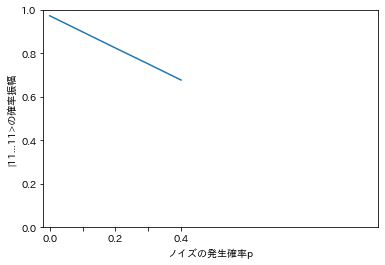

In [32]:
avg_result = []
scores = result

for score in scores:
    avg = np.mean(score)
    avg_result.append(avg)
print(f'平均結果:{avg_result}')
plt.plot(avg_result)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('|11...11>の確率振幅')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 5, step=1))
plt.show()

分散：[0.0, 0.010978836400610115, 0.010978836400610115, 0.0325524594408754, 0.010723304703363079]


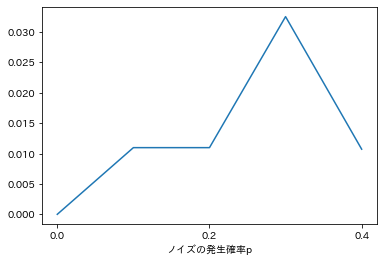

In [33]:
# 分散
variance = []
scores = result
for score in scores:
    v = np.var(score)
    variance.append(v)

print(f'分散：{variance}')

plt.plot(variance)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, times + 1, 2), [i/10 for i in range(0, times + 1, 2) ])

plt.show()

標準偏差：[0.15475333108885692, 0.15475333108885692, 0.15475333108885692, 0.15475333108885692, 0.15475333108885692]


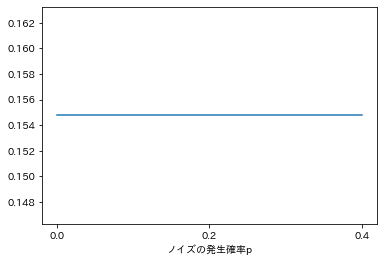

In [34]:
# 標準偏差
scores = result
standard = []
for score in scores:
    std = np.std(scores)
    standard.append(std)

print(f'標準偏差：{standard}')
plt.plot(standard)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, times + 1, 2), [i/10 for i in range(0, times + 1, 2) ])
plt.show()

## p = 0.0, 1.0の特別な場合、どのようなことが発生するか

### p=0の時

In [35]:

dephasing_rate = 0


In [36]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    print(f'確率p = {dephasing_rate}でHadamardが作用されない')
    print(f'確率:{np.linalg.norm(inner_product(state, target_state))}')
    show_distribution(state, nqubits)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        print(f'{k + 1}回目')
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        print(f'確率：{fuga}')
        result.append(fuga)
        show_distribution(state, nqubits)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('|11...11>の確率振幅')


In [37]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover_1(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    # print(f'確率p = {dephasing_rate}でHadamardが作用されない')
    # print(f'確率:{np.linalg.norm(inner_product(state, target_state))}')
    # show_distribution(state, nqubits)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        # print(f'{k + 1}回目')
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        # print(f'確率：{fuga}')
        result.append(fuga)
        # show_distribution(state, nqubits)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.xticks(np.arange(0, 5, step=1))
    plt.ylim(0, 1)



確率p = 0.0でHadamardが作用されない
確率:0.3535533905932737


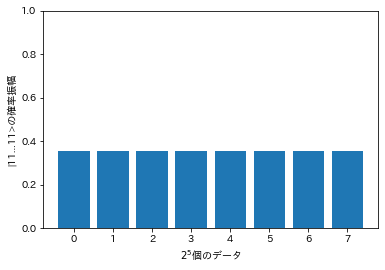

1回目
確率：0.8838834764831837


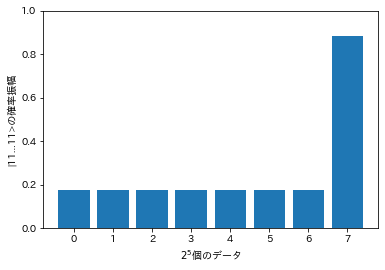

2回目
確率：0.9722718241315015


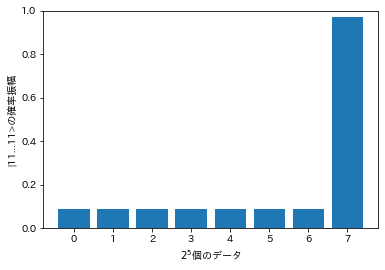

3回目
確率：0.5745242597140687


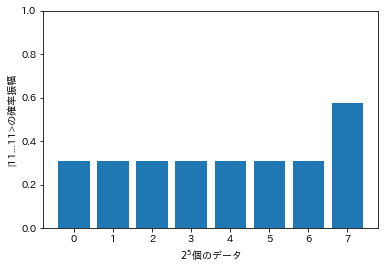

4回目
確率：0.11048543456039785


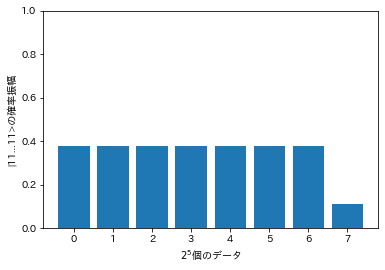

maximal probability 9.722718e-01 is obtained at k = 2
max result:[0.9722718241315015]


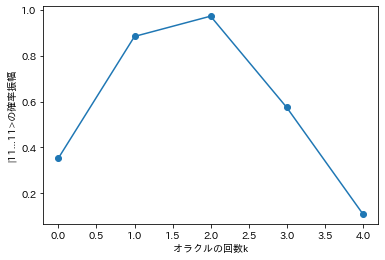

In [38]:
max_result = []
noisy_grover(nqubits, times, 0.0)
print(f'max result:{max_result}')

#### 試行回数を増やす

total result: [[0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.9722718241315015], [0.97227182413150

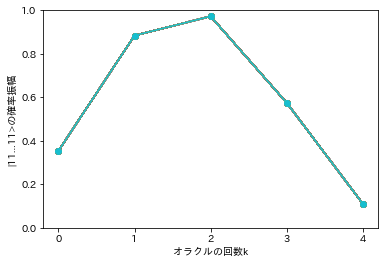

In [39]:
sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, times, dephasing_rate)
    total_result.append(max_result)

print(f'total result: {total_result}')

### p = 1の時

In [40]:
dephasing_rate = 1

確率p = 1でHadamardが作用されない
確率:0.0


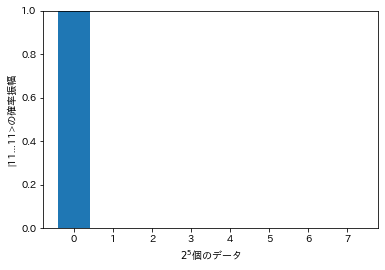

1回目
確率：0.2499999999999999


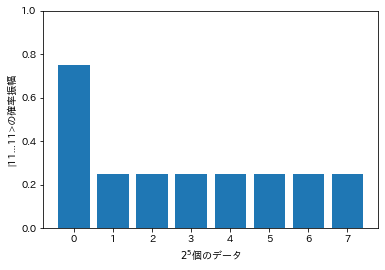

2回目
確率：0.3749999999999996


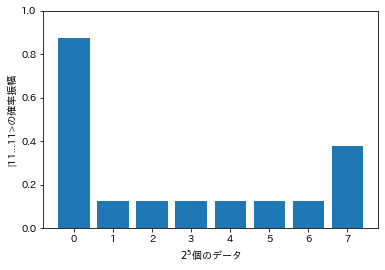

3回目
確率：0.31249999999999956


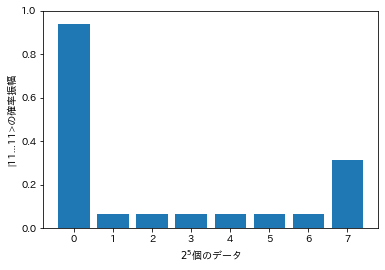

4回目
確率：0.09374999999999986


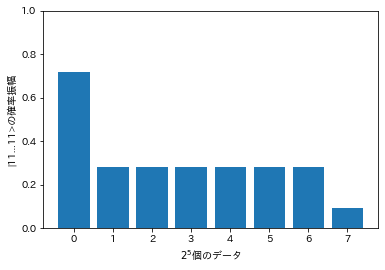

maximal probability 3.750000e-01 is obtained at k = 2


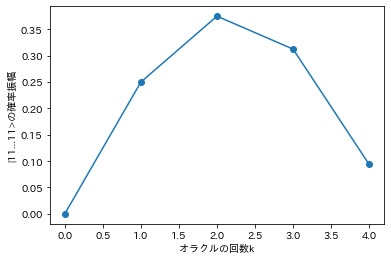

In [41]:
max_result = []
noisy_grover(nqubits, times, dephasing_rate)

ここでは$| 1 \cdots 1 \rangle$を解として設定しているので、$p = 0$だと32個目のデータに解が集まり、ほぼ確率1で解の状態を得ることができ、$p = 1$だと確率があまり上がらない。

確率p = 1でHadamardが作用されない
確率:0.0


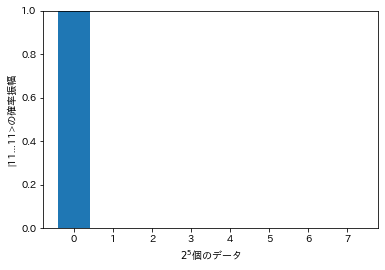

1回目
U_wを作用


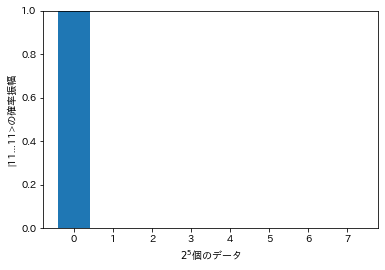

確率：0.2499999999999999


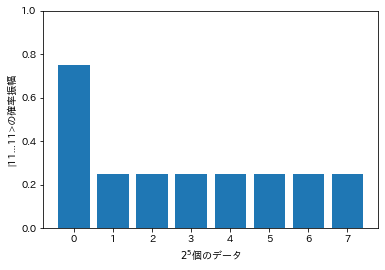

2回目
U_wを作用


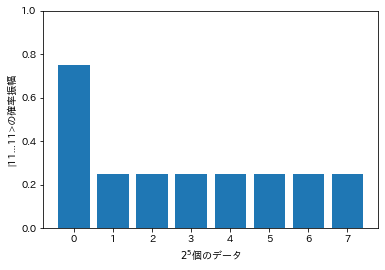

確率：0.3749999999999996


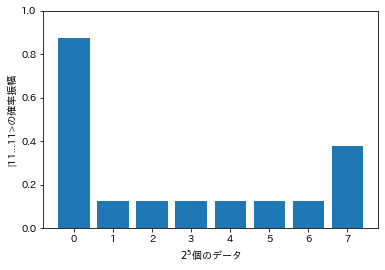

3回目
U_wを作用


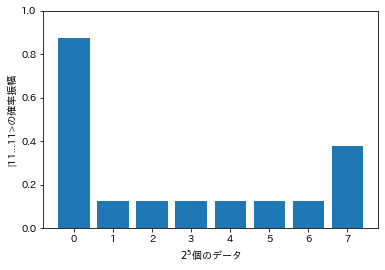

確率：0.31249999999999956


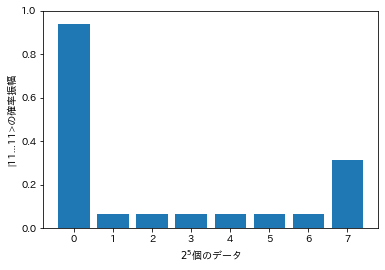

4回目
U_wを作用


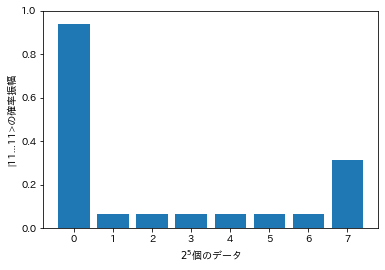

確率：0.09374999999999986


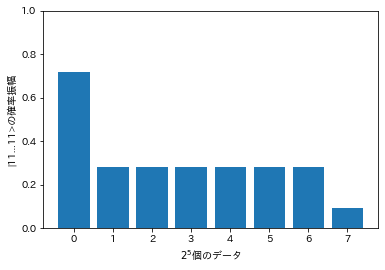

maximal probability 3.750000e-01 is obtained at k = 2


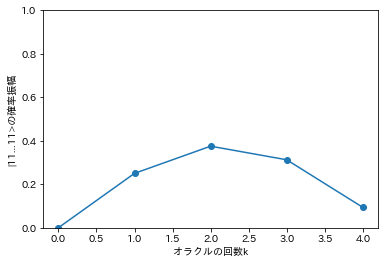

In [42]:
max_result = []
# U_s, U_wを作用させるとき、どのタイミングで変化するか調べる
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    print(f'確率p = {dephasing_rate}でHadamardが作用されない')
    print(f'確率:{np.linalg.norm(inner_product(state, target_state))}')
    show_distribution(state, nqubits)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        print(f'{k + 1}回目')
        U_w.update_quantum_state(state)
        print(f'U_wを作用')
        show_distribution(state, nqubits)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        print(f'確率：{fuga}')
        result.append(fuga)
        show_distribution(state, nqubits)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)

noisy_grover(nqubits, times, dephasing_rate)


#### 試行回数を増やしてみる

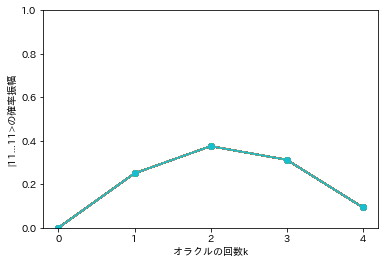

In [43]:
sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    noisy_grover_1(nqubits, times, dephasing_rate)
    total_result.append(max_result)

# print(f'total result: {total_result}')

## p = 0.1, 0.2, 0.5, 0.9の時にどのようなことが発生するか

### p = 0.1の時

確率p = 0.1でHadamardが作用されない
確率:0.3535533905932737


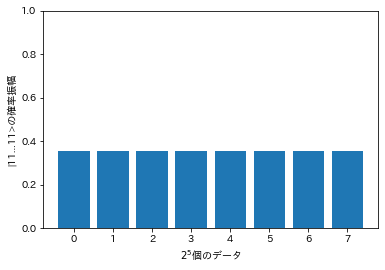

1回目
U_wを作用


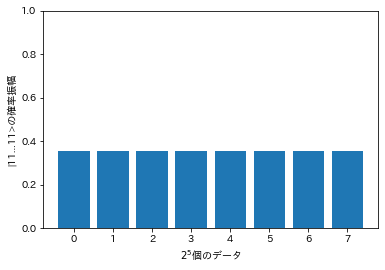

確率：0.8838834764831837


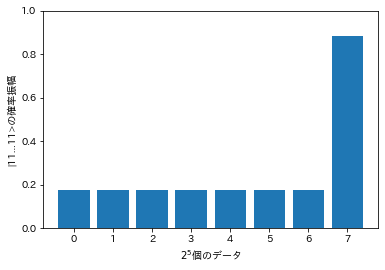

2回目
U_wを作用


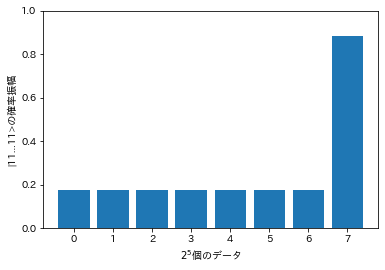

確率：0.9722718241315015


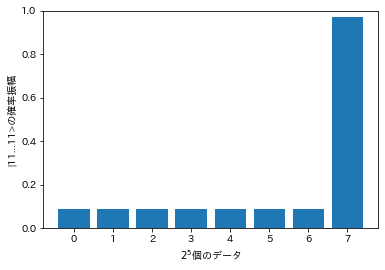

3回目
U_wを作用


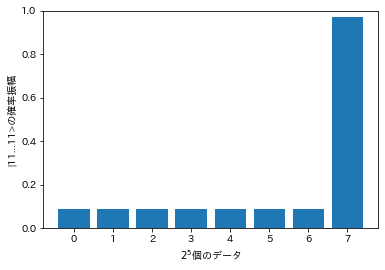

確率：0.5745242597140687


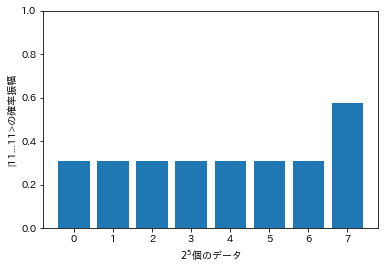

4回目
U_wを作用


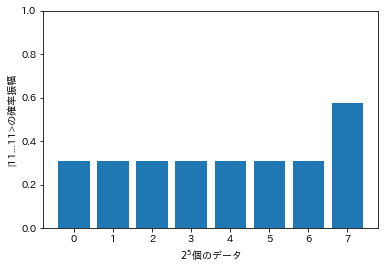

確率：0.11048543456039785


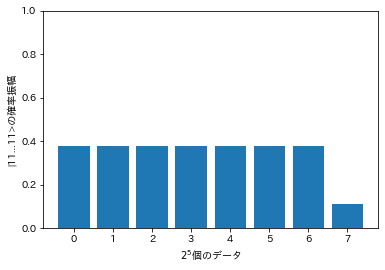

5回目
U_wを作用


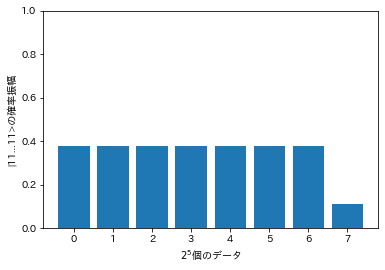

確率：0.7402524115546648


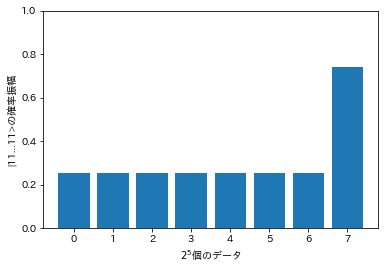

6回目
U_wを作用


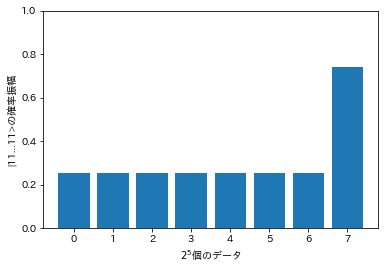

確率：0.999893182771599


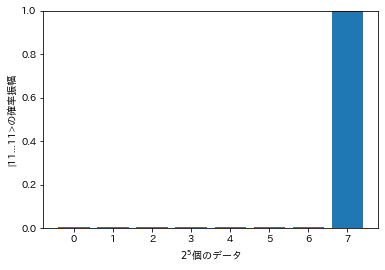

7回目
U_wを作用


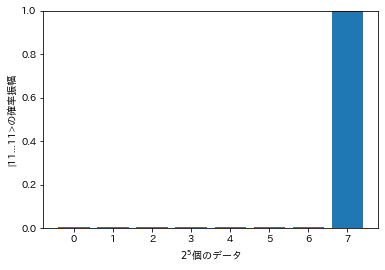

確率：0.7595873626027337


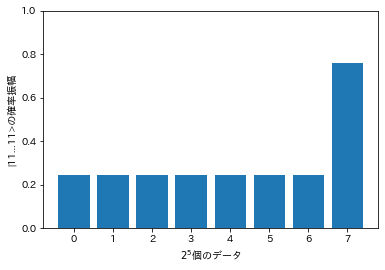

8回目
U_wを作用


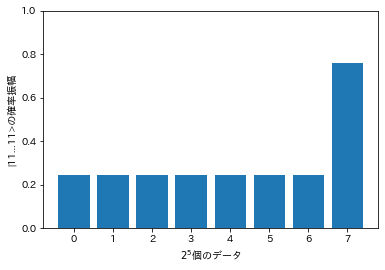

確率：0.13948786113250197


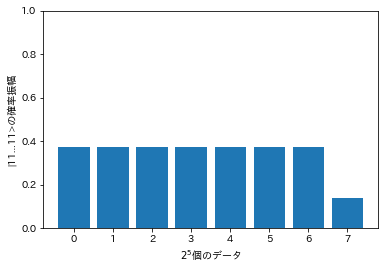

9回目
U_wを作用


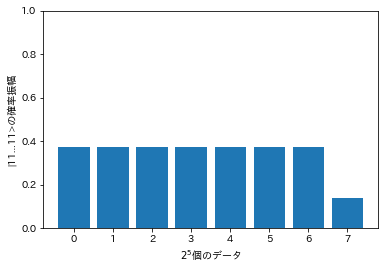

確率：0.55035557090398


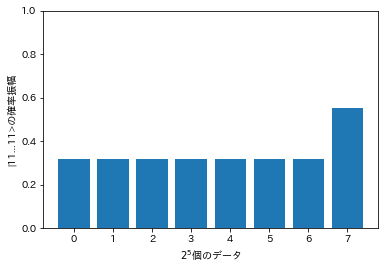

10回目
U_wを作用


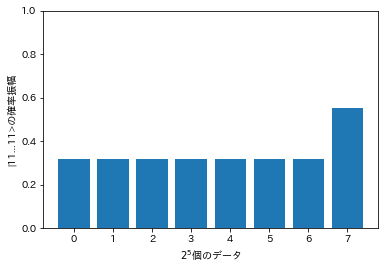

確率：0.9650212174884716


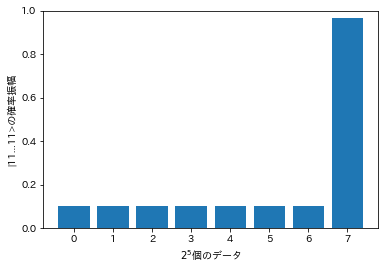

maximal probability 9.998932e-01 is obtained at k = 6


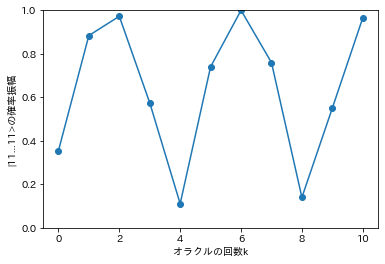

In [44]:
# dephasing_rate = 0.1
dephasing_rate = float(Fraction('0.1'))
noisy_grover(nqubits, 10, dephasing_rate)

#### 試行回数を増やす

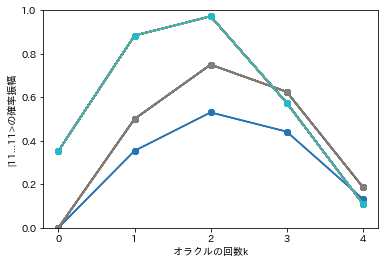

In [45]:
sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, times, dephasing_rate)
    total_result.append(max_result)

# print(f'total result: {total_result}')

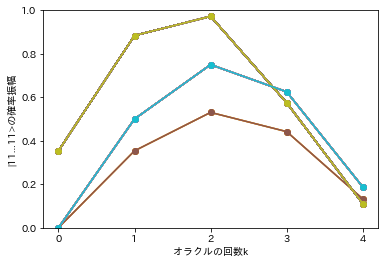

In [46]:
dephasing_rate = 0.1

sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, times, dephasing_rate)
    total_result.append(max_result)


### p = 0.2の時

確率p = 0.2でHadamardが作用されない
確率:0.3535533905932737


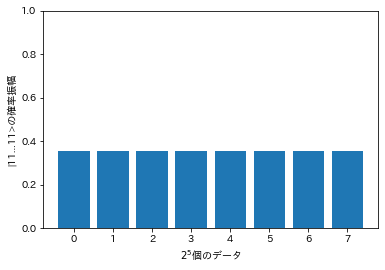

1回目
U_wを作用


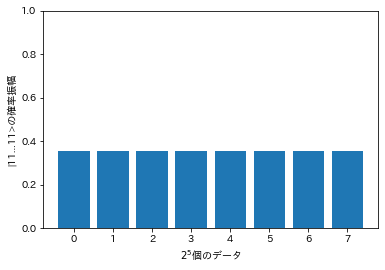

確率：0.8838834764831837


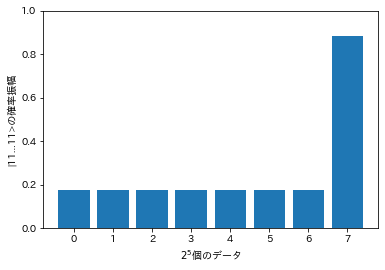

2回目
U_wを作用


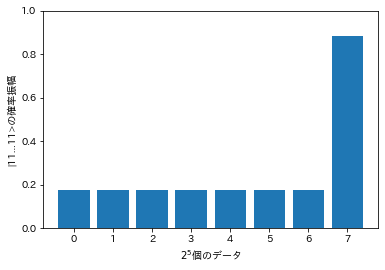

確率：0.9722718241315015


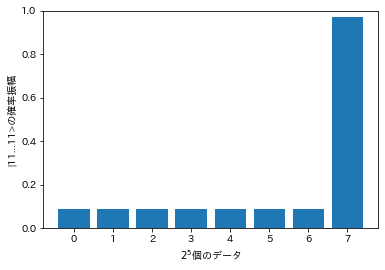

3回目
U_wを作用


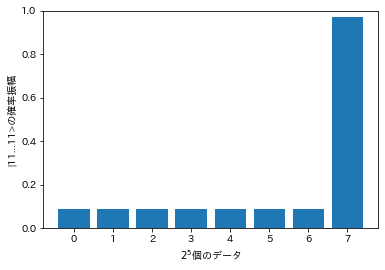

確率：0.5745242597140687


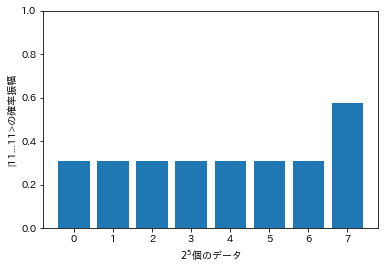

4回目
U_wを作用


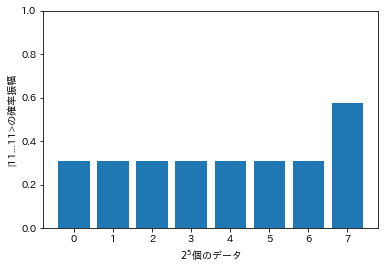

確率：0.11048543456039785


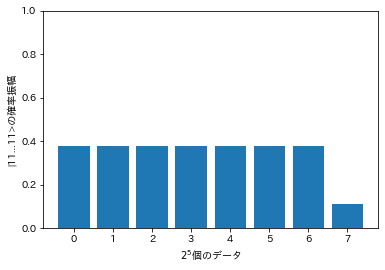

maximal probability 9.722718e-01 is obtained at k = 2


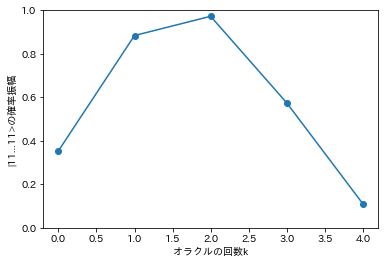

In [47]:
dephasing_rate = 0.2
noisy_grover(nqubits, times, dephasing_rate)

#### 試行回数を増やす

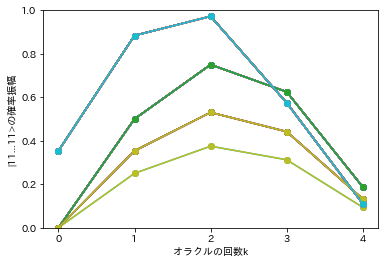

In [48]:
sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, times, dephasing_rate)
    total_result.append(max_result)

### p = 0.5 の時

確率p = 0.5でHadamardが作用されない
確率:0.3535533905932737


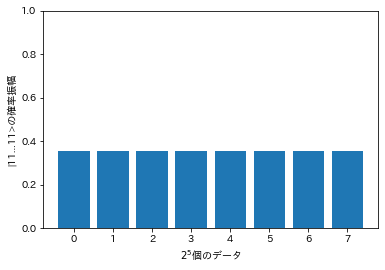

1回目
U_wを作用


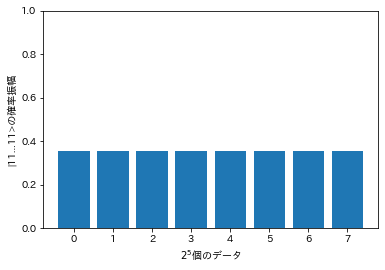

確率：0.8838834764831837


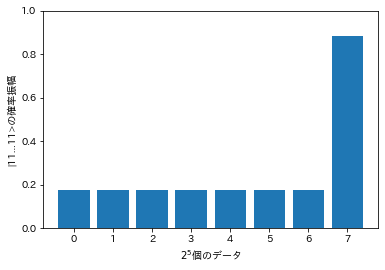

2回目
U_wを作用


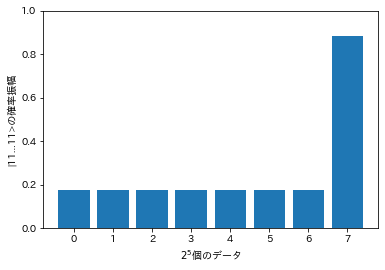

確率：0.9722718241315015


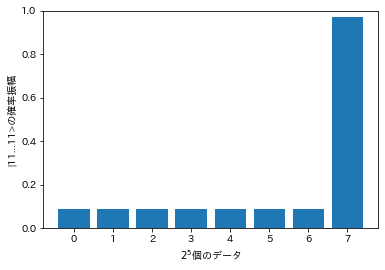

3回目
U_wを作用


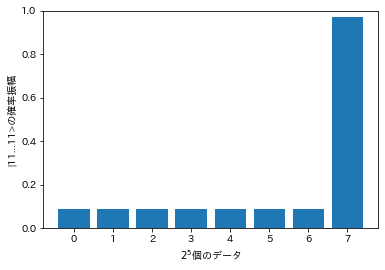

確率：0.5745242597140687


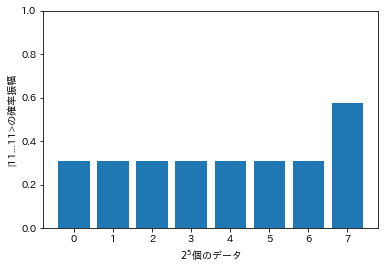

4回目
U_wを作用


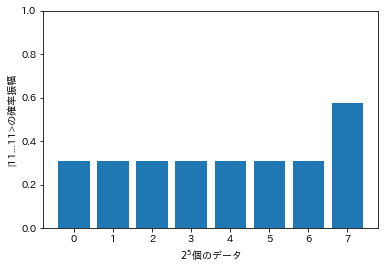

確率：0.11048543456039785


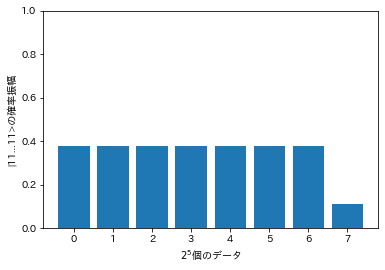

maximal probability 9.722718e-01 is obtained at k = 2


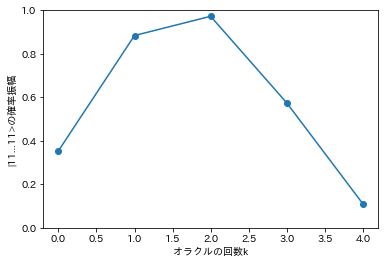

In [49]:
dephasing_rate = 0.5
noisy_grover(nqubits, times, dephasing_rate)

#### 試行回数を増やしてみる

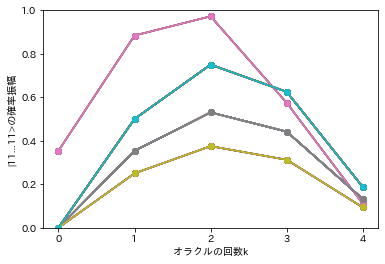

In [50]:
sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, times, dephasing_rate)
    total_result.append(max_result)


### p = 0.9の時

確率p = 0.9でHadamardが作用されない
確率:0.0


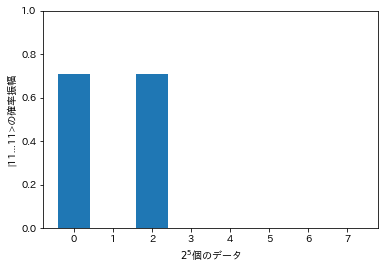

1回目
U_wを作用


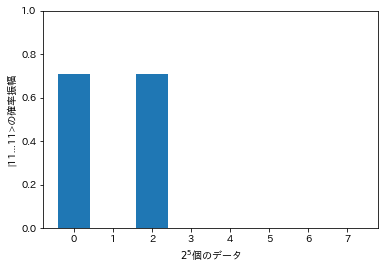

確率：0.35355339059327356


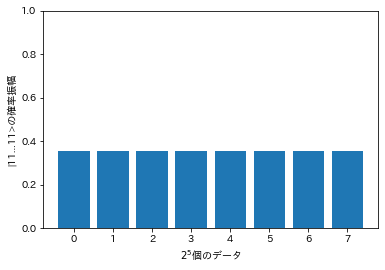

2回目
U_wを作用


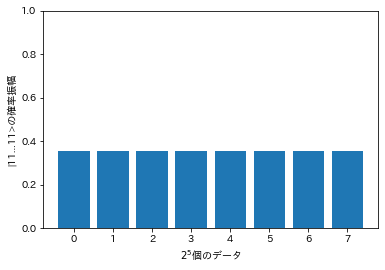

確率：0.5303300858899102


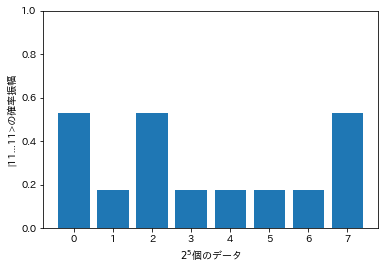

3回目
U_wを作用


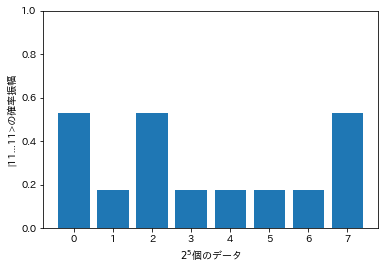

確率：0.44194173824159144


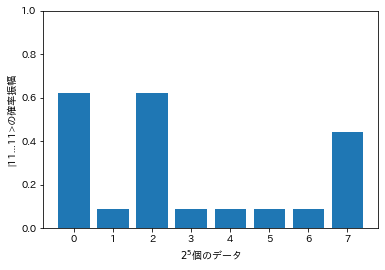

4回目
U_wを作用


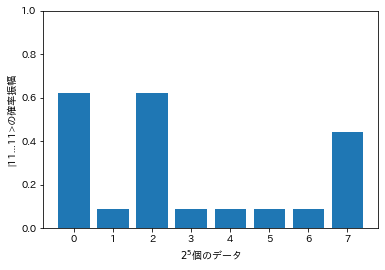

確率：0.13258252147247743


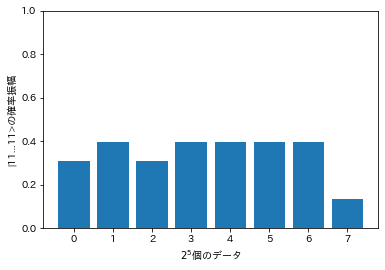

maximal probability 5.303301e-01 is obtained at k = 2


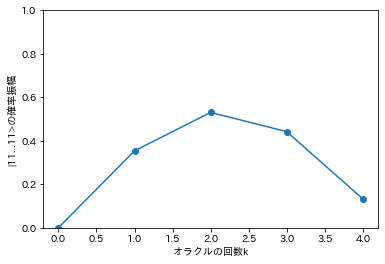

In [51]:
dephasing_rate = 0.9
noisy_grover(nqubits, times, dephasing_rate)

#### 試行回数を増やしてみる

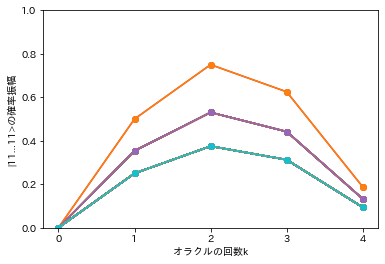

In [52]:
sample_data_times = 100 # サンプルを集める試行回数
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, times, dephasing_rate)
    total_result.append(max_result)

